In [1]:
# A function to avoid tensorflow warnings
from silence_tensorflow import silence_tensorflow
silence_tensorflow()

E0000 00:00:1734859721.493128   26343 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1734859721.496124   26343 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


# **IMPORT LIBRARY**

In [2]:
import os
import cv2
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
from termcolor import colored
import matplotlib.pyplot as plt
import tensorflow as tf
from keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from sklearn.metrics import classification_report, confusion_matrix

In [3]:
print(tf.__version__)

2.18.0


In [4]:
sns.set_style('darkgrid')
warnings.filterwarnings('ignore')

# **IMPORT DATA**

In [5]:
base_dir = './data-tvt'

In [6]:
train_dir = os.path.join(base_dir, 'train')
validation_dir = os.path.join(base_dir, 'validation')
test_dir = os.path.join(base_dir, 'test')

# **Count data and classes**

In [7]:
def num_of_classes(folder_dir, folder_name) :
    classes = [class_name for class_name in os.listdir(train_dir)]
    print(colored(f'number of classes in {folder_name} folder : {len(classes)}', 'blue', attrs=['bold']))

In [8]:
num_of_classes(train_dir, 'train')
num_of_classes(validation_dir, 'validation')
num_of_classes(test_dir, 'test')

number of classes in train folder : 2
number of classes in validation folder : 2
number of classes in test folder : 2


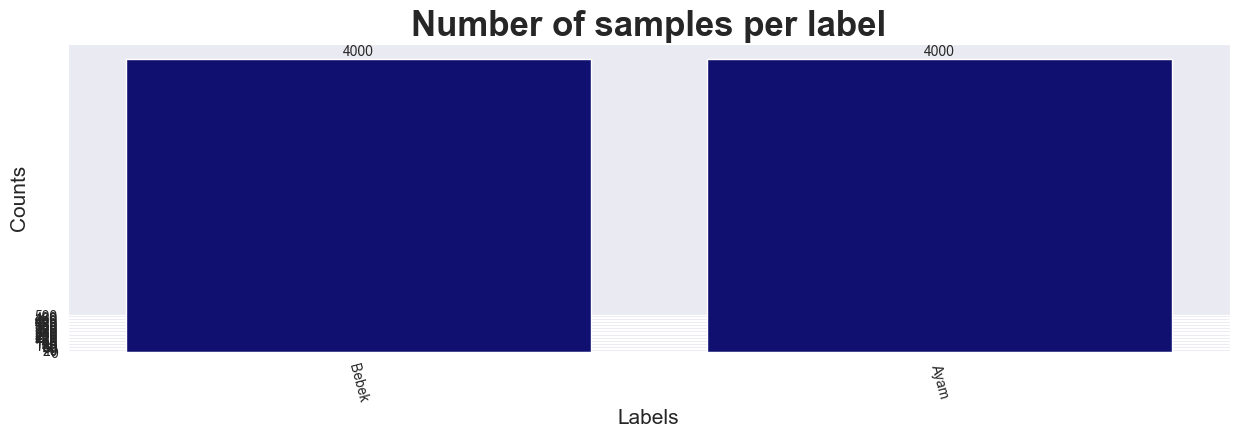

In [9]:
classes = [class_name for class_name in os.listdir(train_dir)]
count = []
for class_name in classes :
    count.append(len(os.listdir(os.path.join(train_dir, class_name))))

plt.figure(figsize=(15, 4))
ax = sns.barplot(x=classes, y=count, color='navy')
plt.xticks(rotation=285)
for i in ax.containers:
    ax.bar_label(i,)
plt.title('Number of samples per label', fontsize=25, fontweight='bold')
plt.xlabel('Labels', fontsize=15)
plt.ylabel('Counts', fontsize=15)
plt.yticks(np.arange(0, 505, 20))
plt.show()

# **Convert data to a DataFrame**

In [10]:
# A function to return DataFrame

def create_df(folder_path) :
    all_images = []
    for class_name in classes :
        class_path = os.path.join(folder_path, class_name)
        all_images.extend([(os.path.join(class_path, file_name), class_name) for file_name in os.listdir(class_path)])
    df = pd.DataFrame(all_images, columns=['file_path', 'label'])
    return df

In [11]:
train_df = create_df(train_dir)
validation_df = create_df(validation_dir)
test_df = create_df(test_dir)

In [12]:
print(colored(f'Number of samples in train : {len(train_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples in validation : {len(validation_df)}', 'blue', attrs=['bold']))
print(colored(f'Number of samples test : {len(test_df)}', 'blue', attrs=['bold']))

Number of samples in train : 8000
Number of samples in validation : 1000
Number of samples test : 1000


# **visualisasi image**

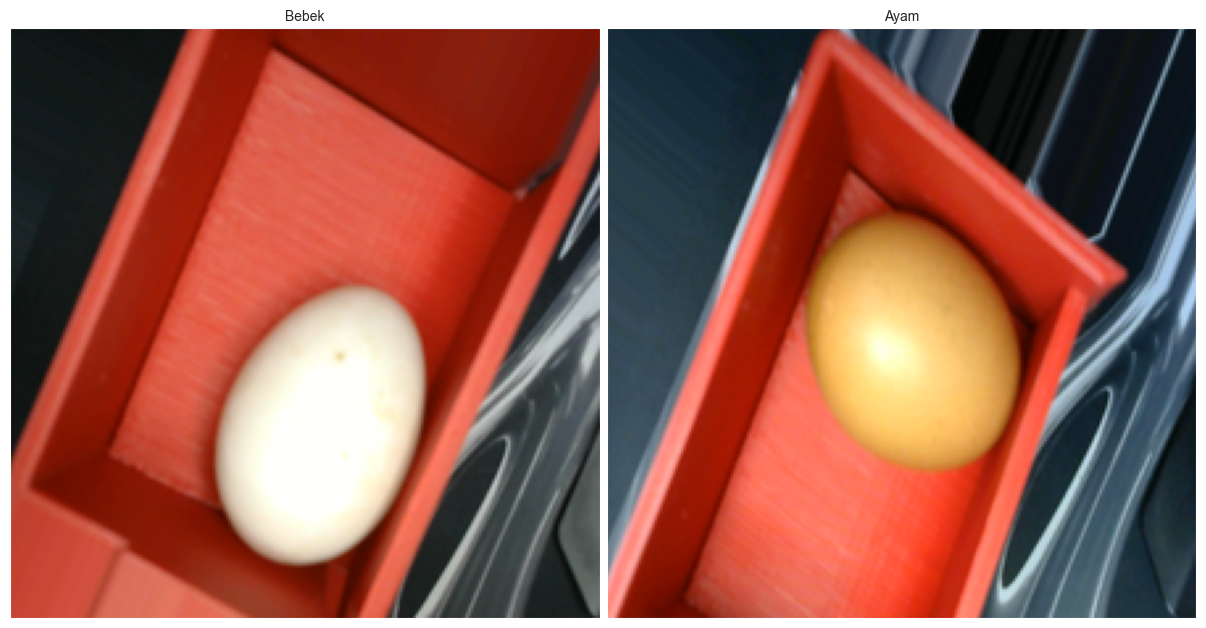

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming train_df is already defined
df_unique = train_df.copy().drop_duplicates(subset=["label"]).reset_index()

# Number of unique labels
num_unique_labels = df_unique.shape[0]

# Calculate the number of rows and columns needed for subplots
nrows = (num_unique_labels // 6) + 1
ncols = min(num_unique_labels, 6)

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(12, 7),
                         subplot_kw={'xticks': [], 'yticks': []})

# Flatten the axes array for easy iteration
axes = axes.flatten()

for i, ax in enumerate(axes[:num_unique_labels]):
    ax.imshow(plt.imread(df_unique.file_path[i]))
    ax.set_title(df_unique.label[i], fontsize=10)

# Hide any remaining subplots if there are any
for ax in axes[num_unique_labels:]:
    ax.axis('off')

plt.tight_layout(pad=0.5)
plt.show()


# **Data generators**

In [14]:
# Train generator

train_datagen = ImageDataGenerator(
    rescale=1./255,                 # Scaled images in range 0 to 1
    )

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,             # Target data
    x_col='file_path',              # X column
    y_col='label',                  # y column
    target_size=(224, 224),         # Resize images  to
    color_mode='rgb',               # Color mode
    class_mode='categorical',       # type of model
    batch_size=32,
    shuffle=True,
    seed=42,

)

Found 8000 validated image filenames belonging to 2 classes.


In [15]:
validation_datagen = ImageDataGenerator(rescale=1./255,)

validation_generator = validation_datagen.flow_from_dataframe(
    dataframe=validation_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 1000 validated image filenames belonging to 2 classes.


In [16]:
# Test generator

test_datagen = ImageDataGenerator(rescale=1./255)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col='file_path',
    y_col='label',
    target_size=(224, 224),
    class_mode='categorical',
    batch_size=32,
    seed=42,
    shuffle=False
)

Found 1000 validated image filenames belonging to 2 classes.


# **Build VGG-16 model**

In [17]:
from tensorflow.keras.applications import VGG16

pre_trained_model = VGG16(
    input_shape=(224, 224, 3),            # Input image size
    include_top=False,                    # model not include top layer
    weights='imagenet',                   # weights type
    pooling='avg'                         # type of pooling layer
)


I0000 00:00:1734859723.975882   26343 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 2179 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3050 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.6


# **Freeze VGG-16 layers**

In [18]:
# Name of layers in VGG-16
for layer in pre_trained_model.layers :
    print(layer.name)


input_layer
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool
global_average_pooling2d


In [19]:
# Freeze all layers, except last layer
# The goal is to train just last layer of pre trained model

pre_trained_model.trainable = True
set_trainable = False

for layer in pre_trained_model.layers :
    if layer.name == 'block_16_expand' :
        set_trainable = True
    if set_trainable :
        layer.trainable = True
    else :
        layer.trainable = False

# **Mendefinisikan model**

In [20]:
# Add custom layers on top of the base model
model = models.Sequential()
model.add(pre_trained_model)

model.add(layers.Flatten())
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dense(2, activation='softmax'))


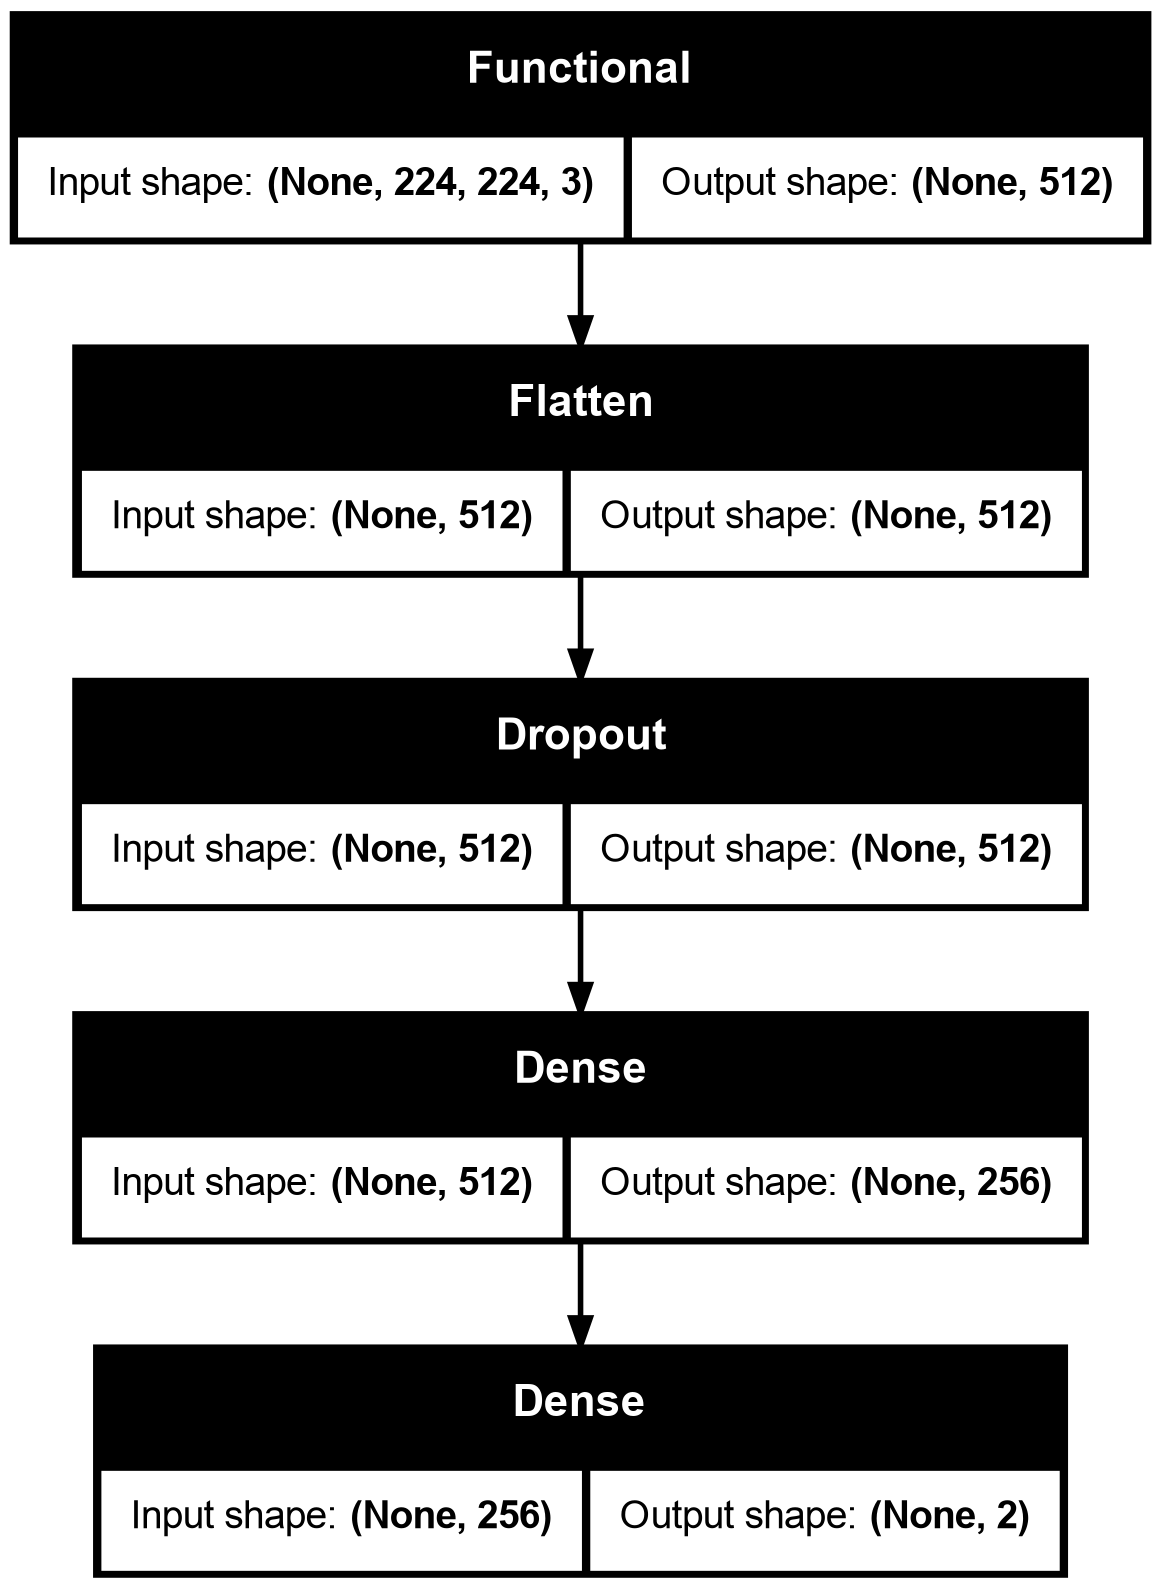

In [21]:
plot_model(model, show_shapes=True, show_layer_names=False, dpi=200)

In [22]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 512)            │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,846,530 (56.64 MB)

 Trainable params: 131,842 (515.01 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

# **Compile Model**

In [23]:
model.compile(optimizer=optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
             metrics=['accuracy'])

In [24]:
# Model CheckPoint
checkpoint_cb = ModelCheckpoint('my_model.keras', save_best_only=True)

# Early Stoping
earlystop_cb = EarlyStopping(patience=1, restore_best_weights=True)

# ReduceLROnPlateau
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5)

# **Train Model**

In [25]:
history = model.fit(
    train_generator,
    steps_per_epoch=len(train_generator),
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator),
    callbacks=[checkpoint_cb, earlystop_cb, reduce_lr]
)

Epoch 1/100


I0000 00:00:1734859725.527350   26433 service.cc:148] XLA service 0x72906000f970 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1734859725.527378   26433 service.cc:156]   StreamExecutor device (0): NVIDIA GeForce RTX 3050 Laptop GPU, Compute Capability 8.6
I0000 00:00:1734859725.700097   26433 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/250 ━━━━━━━━━━━━━━━━━━━━ 57:12 14s/step - accuracy: 0.3750 - loss: 1.4713

I0000 00:00:1734859738.516380   26433 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


250/250 ━━━━━━━━━━━━━━━━━━━━ 60s 184ms/step - accuracy: 0.6260 - loss: 0.7124 - val_accuracy: 0.9570 - val_loss: 0.4293 - learning_rate: 1.0000e-04
Epoch 2/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.9169 - loss: 0.4042 - val_accuracy: 0.9630 - val_loss: 0.2518 - learning_rate: 1.0000e-04
Epoch 3/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.9491 - loss: 0.2464 - val_accuracy: 0.9860 - val_loss: 0.1472 - learning_rate: 1.0000e-04
Epoch 4/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.9724 - loss: 0.1592 - val_accuracy: 0.9920 - val_loss: 0.0963 - learning_rate: 1.0000e-04
Epoch 5/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.9782 - loss: 0.1191 - val_accuracy: 0.9990 - val_loss: 0.0603 - learning_rate: 1.0000e-04
Epoch 6/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/step - accuracy: 0.9790 - loss: 0.0950 - val_accuracy: 1.0000 - val_loss: 0.0442 - learning_rate: 1.0000e-04
Epoch 7/100
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 163ms/s

# **Plot the result of training**

In [26]:
# Convert resutl of training to a DataFrame
result_df = pd.DataFrame(history.history)
result_df.tail()

,accuracy,loss,val_accuracy,val_loss,learning_rate
6,0.985375,0.073219,0.998,0.038390,0.0001
7,0.984750,0.066066,0.999,0.029247,0.0001
8,0.986500,0.057344,1.000,0.022533,0.0001
9,0.985500,0.053352,1.000,0.020368,0.0001
10,0.989250,0.045793,0.998,0.021778,0.0001


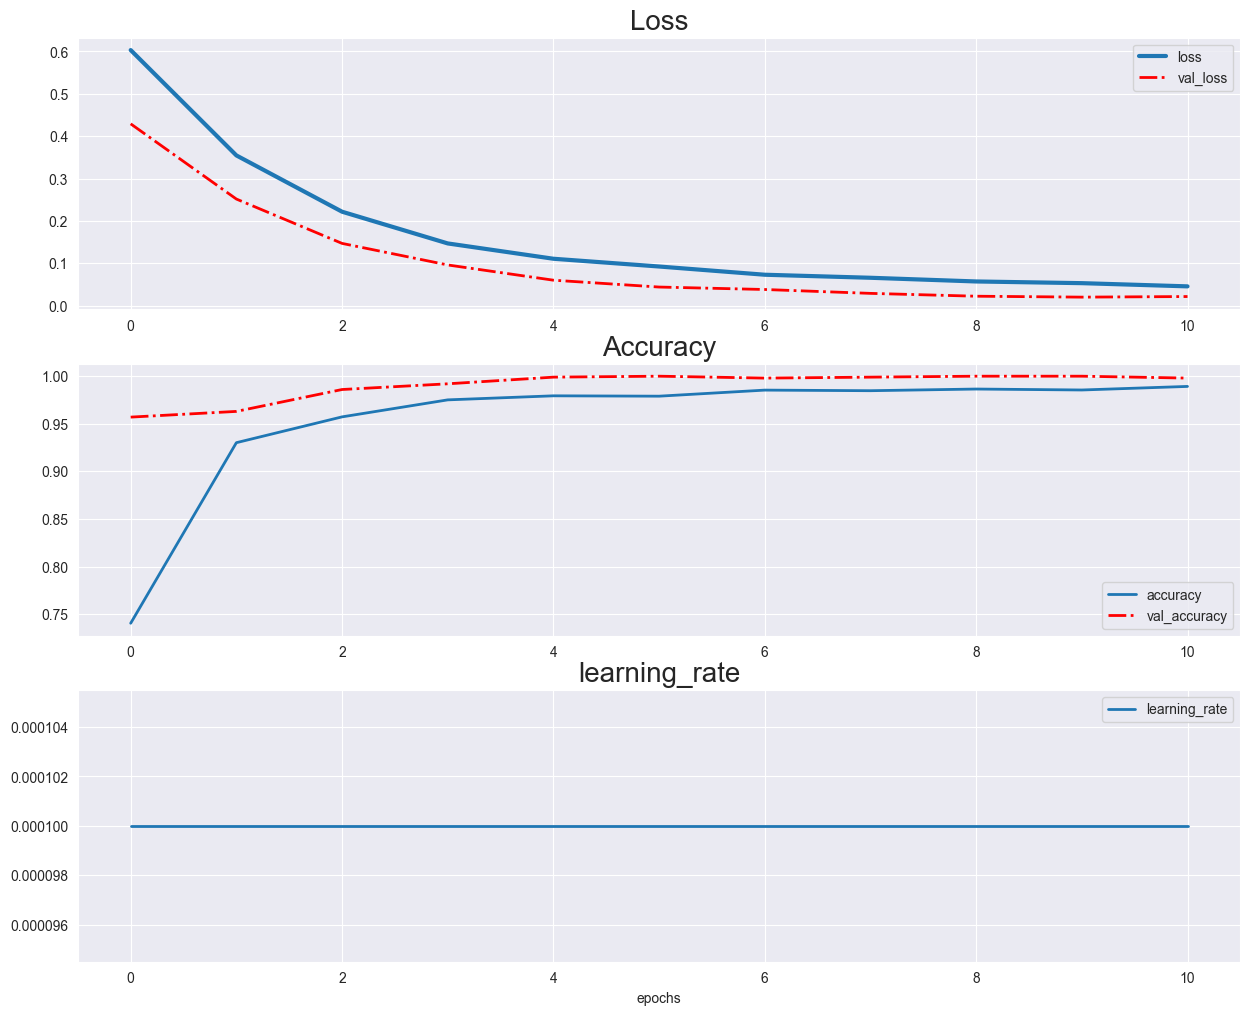

In [27]:
x = np.arange(len(result_df))
fig, ax = plt.subplots(3, 1, figsize=(15, 12))
#  AX0 : Loss
ax[0].plot(x, result_df.loss, label='loss', linewidth=3)
ax[0].plot(x, result_df.val_loss, label='val_loss', linewidth=2, ls='-.', c='r')
ax[0].set_title('Loss', fontsize=20)
ax[0].legend()

#  AX1 : Loss
ax[1].plot(x, result_df.accuracy, label='accuracy', linewidth=2)
ax[1].plot(x, result_df.val_accuracy, label='val_accuracy', linewidth=2, ls='-.', c='r')
ax[1].set_title('Accuracy', fontsize=20)
ax[1].legend()

#  AX2 : Loss
ax[2].plot(x, result_df.learning_rate, label='learning_rate', linewidth=2)
ax[2].set_title('learning_rate', fontsize=20)
ax[2].set_xlabel('epochs')
ax[2].legend()


plt.sharex=True


plt.show()

# **MODEL PREDICTION TEST DATASET**

In [30]:
labels = {value: key for key, value in train_generator.class_indices.items()}

print("Label Mappings for classes present in the training and validation datasets\n")
for key, value in labels.items():
    print(f"{key} : {value}")

Label Mappings for classes present in the training and validation datasets

0 : Ayam
1 : Bebek


In [31]:
predictions = model.predict(test_generator)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 149ms/step


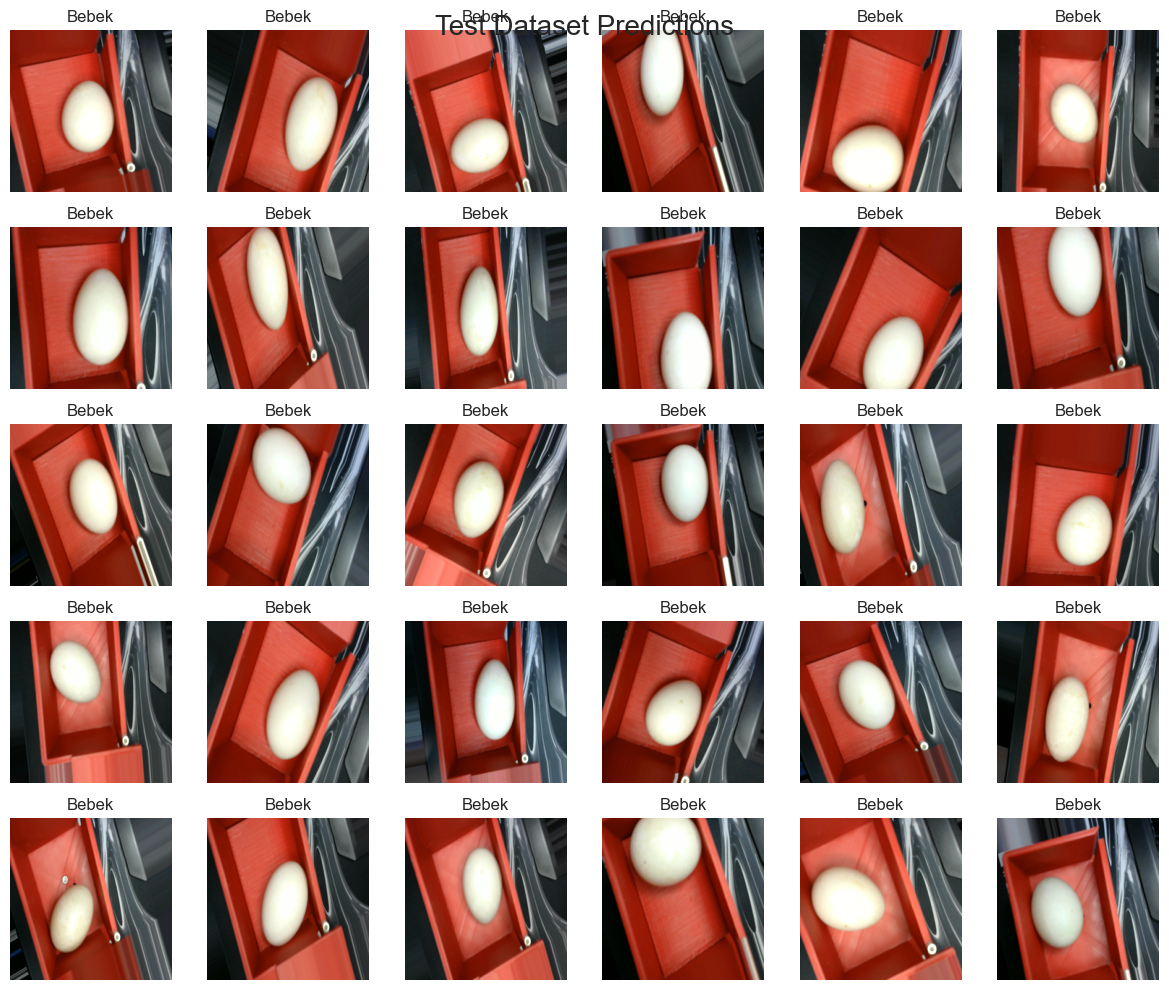

In [32]:
fig, ax = plt.subplots(nrows=5, ncols=6, figsize=(12, 10))
idx = 0

for i in range(5):
    for j in range(6):
        predicted_label = labels[np.argmax(predictions[idx])]
        ax[i, j].set_title(f"{predicted_label}")
        ax[i, j].imshow(test_generator[0][0][idx])
        ax[i, j].axis("off")
        idx += 1

plt.tight_layout()
plt.suptitle("Test Dataset Predictions", fontsize=20)
plt.show()

In [33]:
test_loss, test_accuracy = model.evaluate(test_generator, batch_size=32)

32/32 ━━━━━━━━━━━━━━━━━━━━ 5s 139ms/step - accuracy: 1.0000 - loss: 0.0133


In [34]:
print(f"Test Loss:     {test_loss}")
print(f"Test Accuracy: {test_accuracy} -> {test_accuracy*100:.2f}%")

Test Loss:     0.01605689339339733
Test Accuracy: 1.0 -> 100.00%


# **PLOT CONFUSION MATRIX**

In [35]:
y_hat = np.argmax(predictions, axis=1)
y_true = test_generator.classes

In [36]:
print(classification_report(y_true, y_hat, target_names=labels.values()))

              precision    recall  f1-score   support

        Ayam       1.00      1.00      1.00       500
       Bebek       1.00      1.00      1.00       500

    accuracy                           1.00      1000
   macro avg       1.00      1.00      1.00      1000
weighted avg       1.00      1.00      1.00      1000



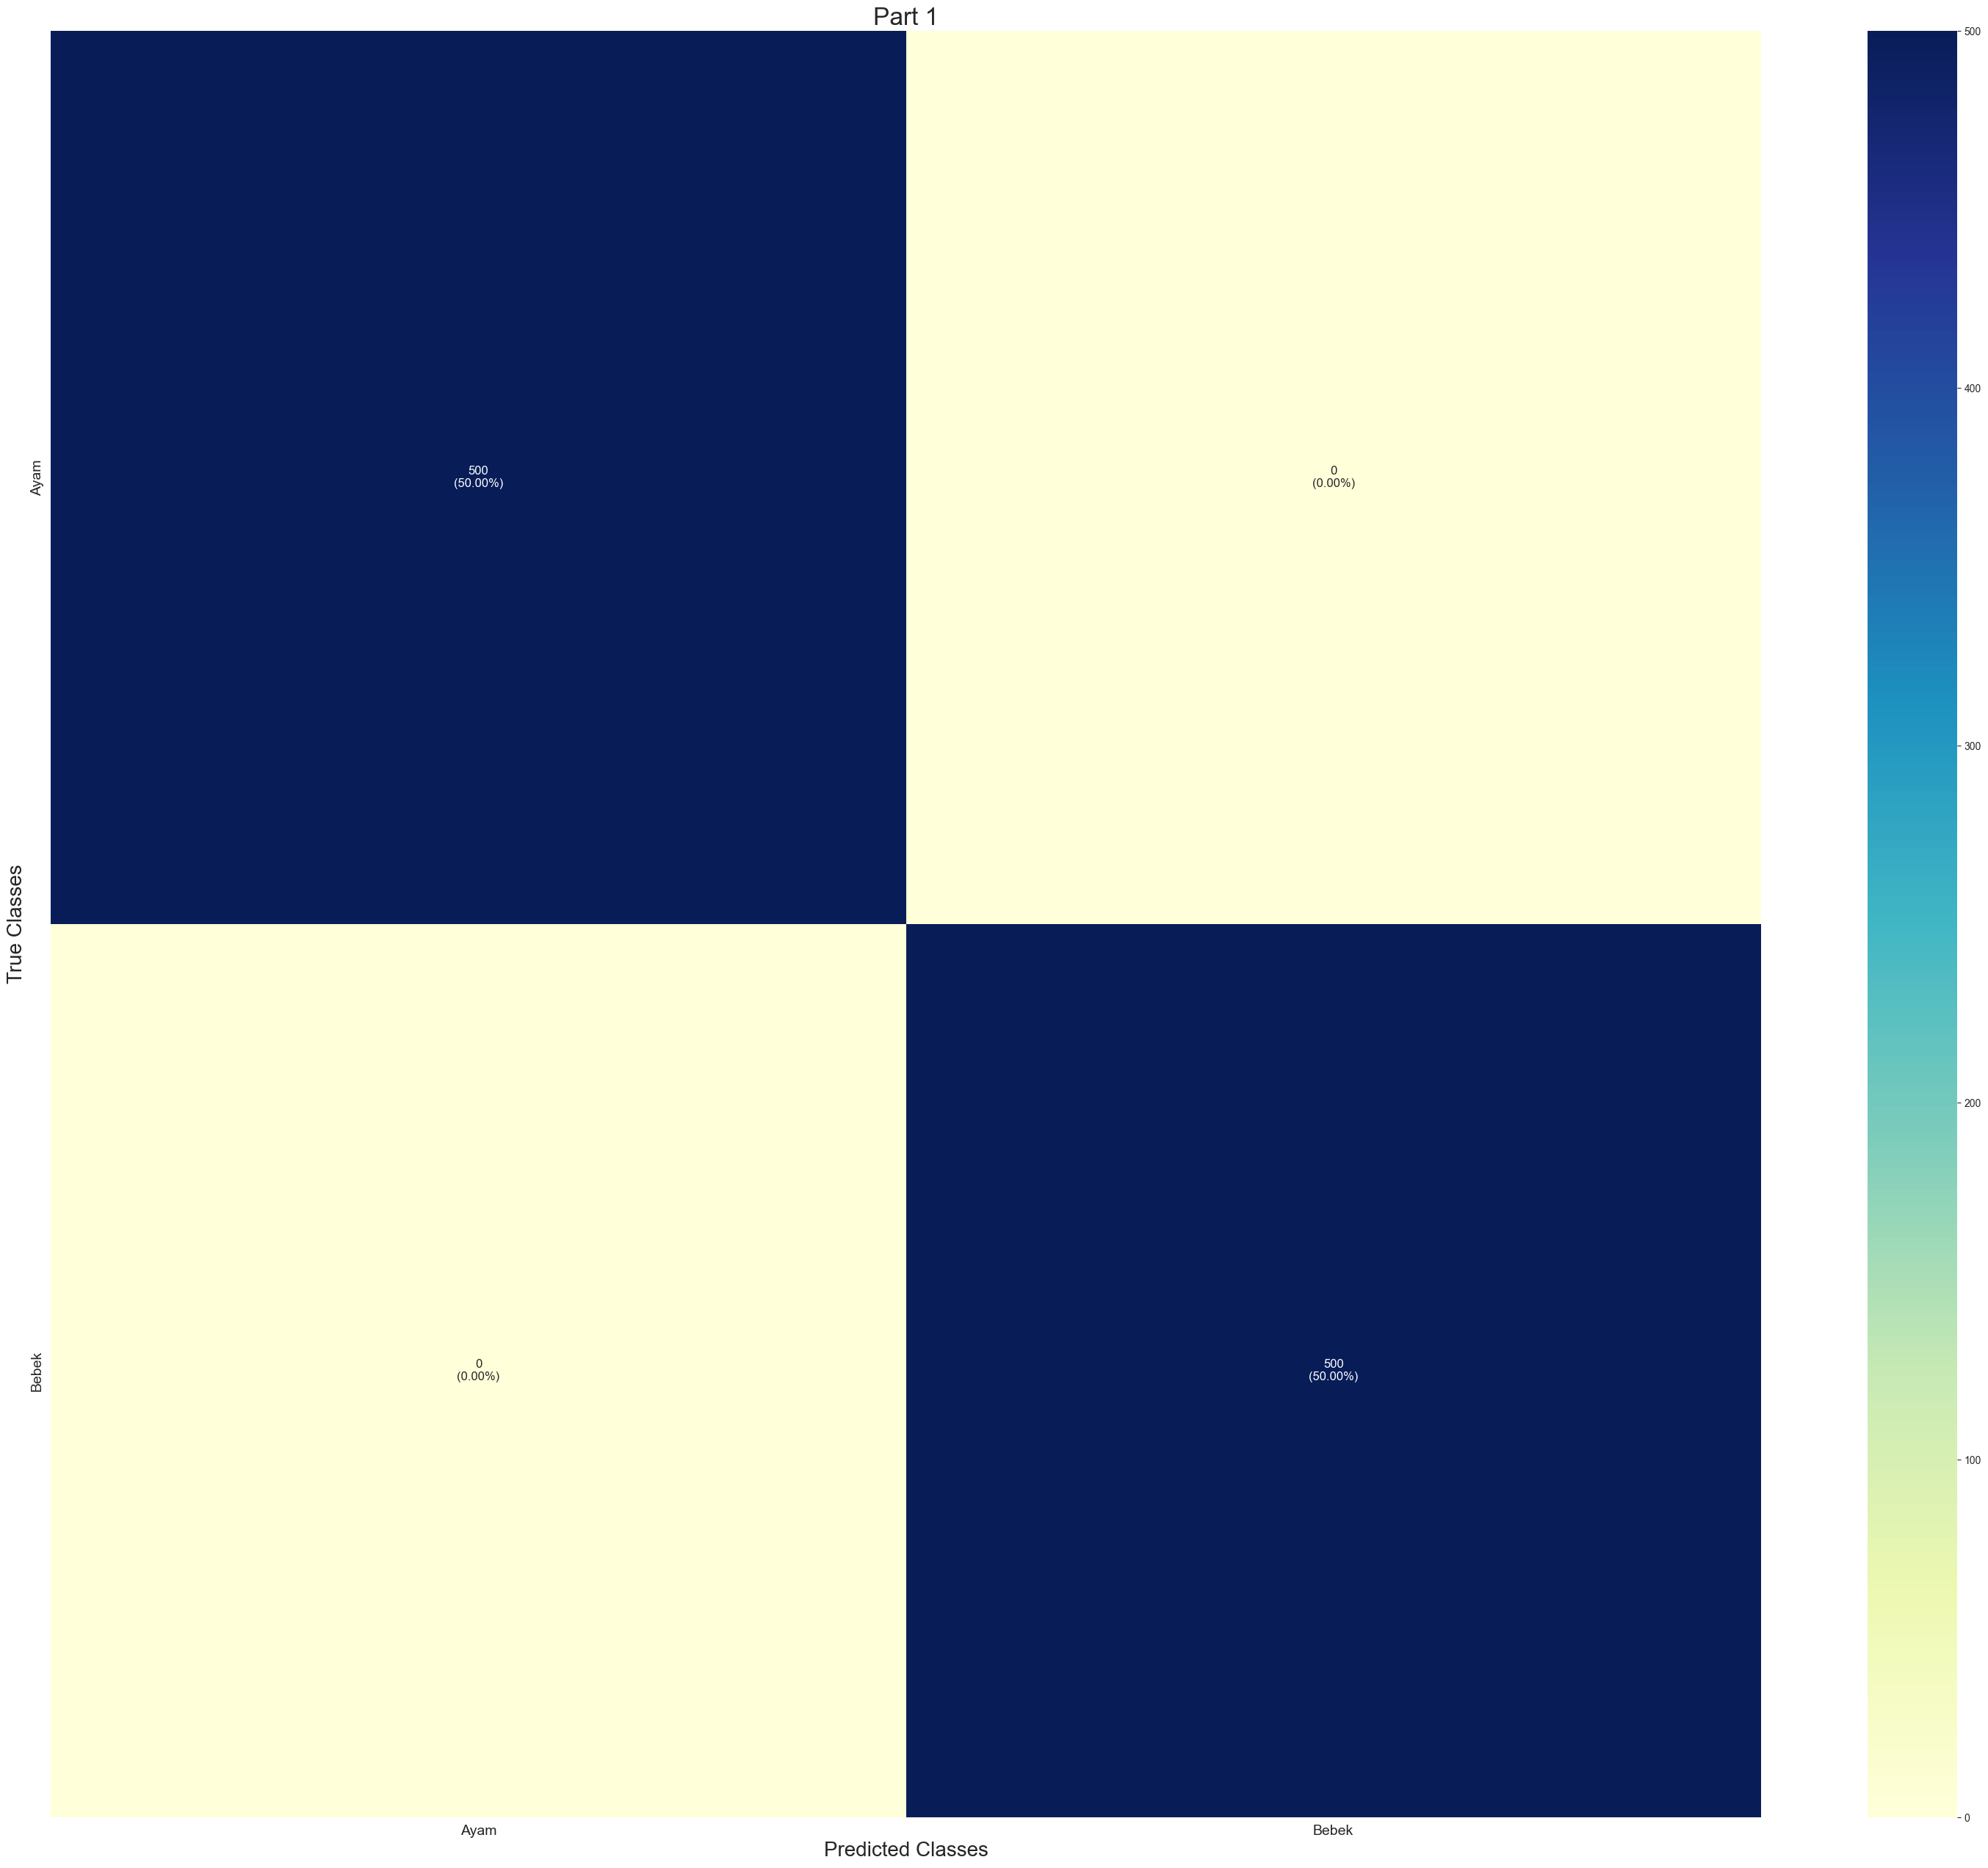

In [37]:
# Hitung confusion matrix
cf_mtx = confusion_matrix(y_true, y_hat)

# Pisahkan menjadi dua bagian
num_classes = 58
mid_point = num_classes // 2

cf_mtx_part1 = cf_mtx[:mid_point, :mid_point]
cf_mtx_part2 = cf_mtx[mid_point:, mid_point:]

class_map_values = list(class_map.values())
class_labels_part1 = class_map_values[:mid_point]
class_labels_part2 = class_map_values[mid_point:]

def prepare_box_class(cf_mtx):
    group_counts = ["{0:0.0f}".format(value) for value in cf_mtx.flatten()]
    group_percentages = ["{0:.2%}".format(value) for value in cf_mtx.flatten()/np.sum(cf_mtx)]
    box_class = [f"{v1}\n({v2})" for v1, v2 in zip(group_counts, group_percentages)]
    return np.asarray(box_class).reshape(cf_mtx.shape)

box_class_part1 = prepare_box_class(cf_mtx_part1)
box_class_part2 = prepare_box_class(cf_mtx_part2)

plt.figure(figsize=(30, 50))  # Ukuran gambar yang besar untuk dua baris

# Heatmap untuk bagian pertama
plt.subplot(2, 1, 1)
sns.heatmap(cf_mtx_part1, xticklabels=class_labels_part1, yticklabels=class_labels_part1, cmap="YlGnBu", fmt="", annot=box_class_part1, annot_kws={"size": 12})
plt.xlabel('Predicted Classes', fontsize=20)
plt.ylabel('True Classes', fontsize=20)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.title('Part 1', fontsize=24)



plt.tight_layout()
plt.show()

# **WRONG PREDICT**

In [38]:
y_true = np.array(y_true)
print(y_true.shape)

(1000,)


In [39]:
errors = (y_true - y_hat != 0)
error_indices = np.where(errors)[0]
y_true_errors = y_true[error_indices]
y_hat_errors = y_hat[error_indices]


In [40]:
# Menghitung jumlah total prediksi
total_predictions = y_true.shape[0]

# Menghitung jumlah prediksi yang salah
total_errors = y_true_errors.shape[0]

# Menghitung persentase prediksi yang salah
error_percentage = (total_errors / total_predictions) * 100

print(f"Jumlah total prediksi: {total_predictions}")
print(f"Jumlah prediksi yang salah: {total_errors}")
print(f"Persentase prediksi yang salah: {error_percentage}%")

Jumlah total prediksi: 1000
Jumlah prediksi yang salah: 0
Persentase prediksi yang salah: 0.0%


In [41]:
test_images = test_generator.filenames
test_img = np.asarray(test_images)[errors]

In [43]:
model.save("./model_vgg16.h5")